# PTC-3569 - Introdução à Inteligência Computacional
# Trabalho Final
Mariana Frasson Amaral Arruda - NUSP 10736802

1) Resolver o problema da classificação de dígitos manuscritos utilizando o banco
de dados MNIST e redes convolucionais. Roteiro a seguir:
Utilizar a linguagem Python 3 e as bibliotecas Keras e TensorFlow, e o Modelo abaixo:

Dígito MNIST

↓

Conv2D (filtros = 64)

MaxPooling2D (2)

Conv2D (filtros = 64)

MaxPooling2D (2)

Conv2D (filtros = 64)

Dropout

Dense (10)

Ativação ( softmax)

↓

0 ... 9


Utilizar o código cnn-mnist-1.4.1.py, disponível em:

https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras

Apresentar explicações e comentários pessoais detalhados das linhas relevantes do código, em especial as que se referem a dimensões de tensores e kernels, filtros, otimização (treinamento e teste), função de desempenho (loss function), e regularização.
Apresentar os resultados da classificação em termos de percentagem de acertos, para treinamento e teste, para diferentes tipos de otimização e diferentes valores dos hiperparâmetros, como na regularização (valores
de Dropout).

#### Solução

Esse trabalho foi resolvido usando a ferramenta Google Colab. O link para o notebook é [esse](https://colab.research.google.com/drive/1RU9Q5SMkVW9Yj24xRuYzEu8gAdw21gUp?authuser=1#scrollTo=bx68iRuvGD9B). 

O objetivo é criar uma rede neural para identificar números baseada em dígitos manuscritos. Por exemplo, quando o input da rede é uma imagem do número 8 manuscrito, a predição correspondente deve ser o dígito 8. Esse é um problema clássico de redes de classifição.

Para treinar e validar o modelo é necessário um conjunto de dados suficientemente grande de dígitos manuscritos. O dataset MNIST (Modified National Institute of Standards and Technology) é considerado como referência dentre os datasets para _deep learning_.

Antes de discutir o modelo de classificação, é necessário entender o conjunto de dados. Ele é uma coleção de dígitos manuscritos de 0 a 9 e possui um conjunto de treino de 60.000 imagens e 10.000 para teste.

In [ ]:
# Carregando as bibliotecas
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist

# Carregando dataset mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Computando o número de rótulos (labels)
num_labels = len(np.unique(y_train))

# Contando o número de rótulos (labels) no conjunto de treino
unique, counts = np.unique(y_train, return_counts=True)
print("Train labels and count: ", dict(zip(unique, counts)))

# O mesmo para teste
unique, counts = np.unique(y_test, return_counts=True)
print("Test labels and count: ", dict(zip(unique, counts)))

Train labels and count:  {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}
Test labels and count:  {0: 980, 1: 1135, 2: 1032, 3: 1010, 4: 982, 5: 892, 6: 958, 7: 1028, 8: 974, 9: 1009}


Abaixo temos um exemplo de 25 amostras do conjunto de dados.

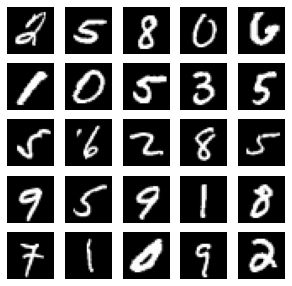

In [ ]:
# Amostrar 25 dígitos do conunto de treino
indexes = np.random.randint(0, x_train.shape[0], size=25)
images = x_train[indexes]
labels = y_train[indexes]

# Apresentar a imagem dos dígitos
plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')

Nesse caso, é necessário redimensionar os dados dependendo do tipo da camada de entrada da rede. Para essa CNN, o tamanho da imagem é 28, ou seja, as dimensões serão (28,28,1). O 1 é relacionado à cor dos dígitos, que é numa escala de cinza.

Além disso, um formato mais adequado para a cada predição de uma rede neural é chamado de vetor one-hot ou vetores de variáveis dummy. É um vetor de 10 dimensões com todos os elementos iguais a zero, exceto para o índice da classe do dígito. Por exemplo, para o rótulo igual a 2, o vetor one-hot equivalente é [0,0,1,0,0,0,0,0,0,0].

In [ ]:
# Convertendo para variáveis "dummy" (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Calculando as dimensões da imagem
image_size = x_train.shape[1]

# Redimensionando e normalizando os dados 
x_train = np.reshape(x_train,[-1, image_size, image_size, 1])
x_test = np.reshape(x_test,[-1, image_size, image_size, 1])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

Depois de preparar o conjunto de dados, é possível prosseguir para o modelo. 

O modelo é implementado usando a API Sequential do Keras, que é suficiente já que ela requer um dado de entrada e um dado de saída.

O modelo proposto possui três camadas. A primeira e segunda camadas são idênticas (Conv2D-ReLU-MaxPool), já a terceira camada é definida por Conv2D-ReLU-Dropout.

- A operação de convolução é quando o kernel pode ser visualizado como um fragmento retangular que percorre toda a imagem da esquerda para a direita e de baixo para cima. Isso transforma a imagem de entrada em um `feature map`, que é a representação do que o kernel aprender da imagem de entrada. Esse `feature map` é então transformado em outro na camada seguinte e assim sucessivamente. O número de `feature maps` gerados por Conv2D é controlado pelo argumento `filters`.

As imagens a seguir mostram a operação de convolução e como o `feature map` é computado.

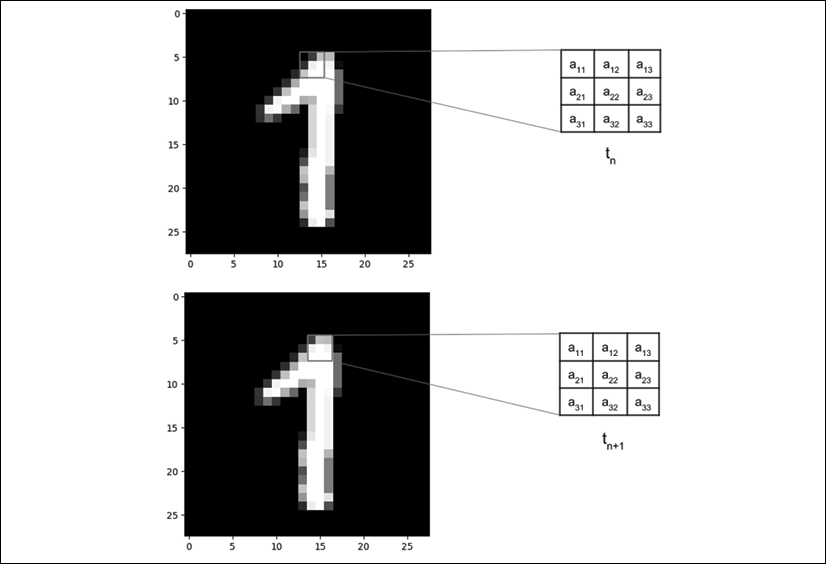

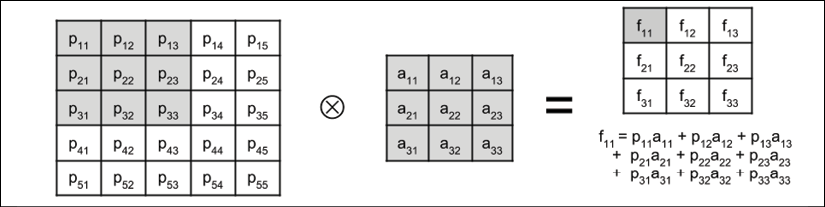

Como o problema de classificação de dígitos é um processo não linear, adicionar uma ativação `relu` possibilita a modelagem não linear. Existem outras funções não lineares que podem ser usadas, mas `relu` é mais usada e também computacionalmente eficiente devido à sua simplicidade. A função é mostrada abaixo:

$$ ReLu(x) = max(0,x) $$

- A camada de MaxPooling2D com os argumentos `pool_size=2` comprime cada ` feature map`, ou seja, transforma cada fragmento de tamanho pool_size x pool_size em um ponto do `feature map`. O valor é igual ao máximo de todos os pontos, conforme na imagem.

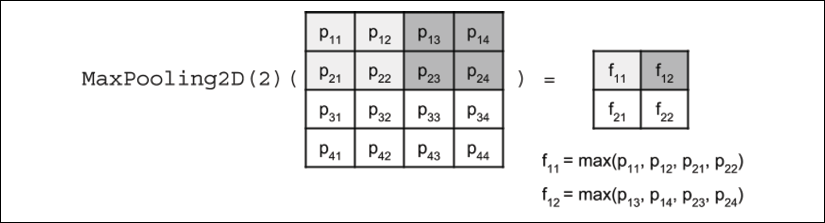

- `Flatten`é usado para converter o output da última operação de MaxPooling2D em um vetor para uma camada de Dropout.

- As redes neurais tendem a memorizar os dados do conjunto de treino e acabam falhando nos dados de teste, o que é um problema de generalização da rede. Para evitar essa tendência, o modelo usa uma camada de regularização comum que é `Dropout`. Dada uma taxa de dropout (dropout rate), essa função aleatoriamente remove aquela fração de unidades de participarem da próxima camada. Isso torna a rede mais robusta para dados não vistos antes já que ela é treinada para predizer corretamente, mesmo se alguns dados estão faltantes.


- A camada de saída possui 10 unidades, correspondentes aos 10 dígitos, seguida de uma camada de ativação `softmax`, que pose ser expressa da seguinte forma:

$$softmax(x_i)=\frac{e^{x_i}}{\sum_{j=0}^{N-1}e^{x_i}}$$

Essa equação é aplicada em todos os $N=10$ outputs, $x_i$ para $i = 0, 1, ..., 9$ para a predição final. Cada output predito é a probabilidade de que o índice é o dígito correto da imagem de input. A soma das probabilidades para todos os outputs deve ser 1.


- A medida da distância do tensor predito para a classificação correta é chamado de loss (perda). Para problemas de classificação e após o uso da camada de ativação `softmax`, é possível usar `categorical_crossentropy` (esse caso) ou `mean_squared_error`.

- Com a otimização, o objetivo é minimizar a função perda (loss). A ideia é que se a loss for reduzida a um nível aceitável, o modelo indiretamente aprendeu a função que mapeia os dados de entrada para os dados de saída. As métricas de performance do modelo são usadas para determinar se um modelo aprendeu a distribuição dos dados e a métrica default no Keras é `loss`. Durante o treinamento outras métricas podem ser incluídas, como a acurácia (accuracy), o que é feito nesse caso. Ela pode ser definida como:

$$Accuracy = \frac{Número \space de \space predições \space corretas}{Número \space total \space de \space predições}$$

No Keras, existem várias escolhas para otimizadores. O que foi usado aqui `Adaptive Moments (Adam)` é um dos mais usados.

- Para avaliar a performance do modelo, é possível ver os efeitos de cada variação nas camadas.

Abaixo temos os códigos para todas as etapas descritas até agora.

In [ ]:
# Configuração dos parâmetros da rede
# A imagem é processada quadrada e em escala de cinza
input_shape = (image_size, image_size, 1)
batch_size = 128
kernel_size = 3
pool_size = 2
filters = 64
dropout = 0.2

In [ ]:
# model é uma CNN-ReLU-MaxPooling
model = Sequential()

# CNN com 3 camadas para classificação dos dígitos MNIST 
# Primeira e segunda camadas: Conv2D-ReLU-MaxPool
model.add(Conv2D(filters=filters,
                 kernel_size=kernel_size,
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size))
model.add(Conv2D(filters=filters,
                 kernel_size=kernel_size,
                 activation='relu'))
model.add(MaxPooling2D(pool_size))

# Terceira camada: Conv2D-ReLU-Dropout
model.add(Conv2D(filters=filters,
                 kernel_size=kernel_size,
                 activation='relu'))
model.add(Flatten())

# dropout adicionado para regularização
model.add(Dropout(dropout))

# Quarta camada - Dense(10)
# A camada de output é um vetor dummy (one-hot) de 10 dimensões
model.add(Dense(num_labels))

# Ativação do Output: softmax
model.add(Activation('softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 3, 64)          36928     
_________________________________________________________________
flatten_2 (Flatten)          (None, 576)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 576)              

Abaixo temos a representação gráfica do CNN classificador de dígitos MNIST.

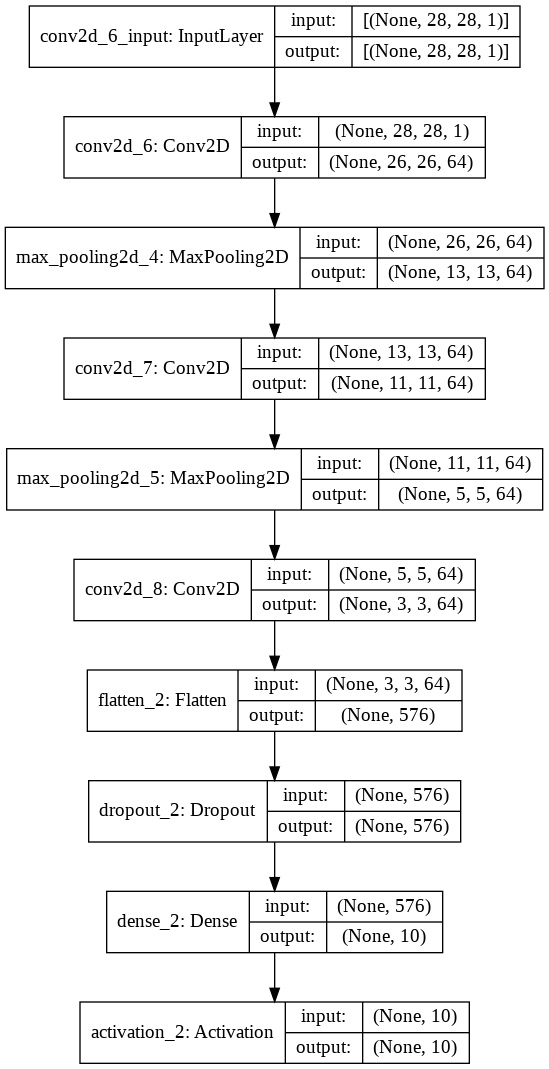

In [ ]:
# Requer instalação do pydot
# pip install pydot
plot_model(model, to_file='cnn-mnist.png', show_shapes=True)

In [ ]:
# Função loss para o vetor dummy (one-hot)
# Otimizador: Adam
# Podemos usar a métrica acurácia (accuracy) para avaliar modelos de classificação
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Treinando a rede
model.fit(x_train, y_train, epochs=10, batch_size=batch_size)

_, acc = model.evaluate(x_test,
                        y_test,
                        batch_size=batch_size,
                        verbose=0)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

Epoch 1/10
469/469 [==============================] - 4s 7ms/step - loss: 0.2569 - accuracy: 0.9210
Epoch 2/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0660 - accuracy: 0.9794
Epoch 3/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0466 - accuracy: 0.9856
Epoch 4/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0386 - accuracy: 0.9880
Epoch 5/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0310 - accuracy: 0.9905
Epoch 6/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0276 - accuracy: 0.9911
Epoch 7/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0241 - accuracy: 0.9923
Epoch 8/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0198 - accuracy: 0.9936
Epoch 9/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0174 - accuracy: 0.9943
Epoch 10/10
469/469 [==============================] - 3s 7ms/step - loss: 0.0165 - accuracy: 0.9947

O maior incremento na acurácia ocorreu na primeira camada e é possível alcançar uma acurácia de 99.4% com uma rede de 3 camadas com 64 `feature maps` por camada, usando o otimizador Adam com um dropout = 0.2. CNNs são mais eficientes para os parâmetros e possuem maior acurácia do que MLPs. Além disso, também são adequadas para aprendizado de representações de dados sequenciais, imagens e vídeos.

2) Detecção de objetos usando Aprendizagem Profunda (Deep Learning).
Neste exercício o aluno deverá criar uma rede neural convolucional (CNN) para reconhecer (detectar) objetos em imagens, utilizando o Toolbox Deep Learning e outros do Matlab.

Metodologia a ser utilizada:

Baixar o banco de dados de imagens CIFAR – 10

Criar uma CNN de acordo com:

https://www.mathworks.com/help/vision/examples/object-detection-using-deep-learning.html?s tid=srchtitle

• imageInputLayer – Camada de entrada de imagem

• convolution2dLayer – Camada de convolução 2D para RNs
convolucionais

• reluLayer – Camada de unidade linear retificada (ReLu)

• maxPooling2dLayer - Camada de max pooling

• fullyConnectedLayer – Camada totalmente conectada

• softmaxLayer – Camada softmax

• classificationLayer – Camada de saída de classificação

Treinar a CNN com o CIFAR – 10

Validar o treinamento da CNN com o CIFAR – 10

Obter imagens (fotos) com objetos a serem reconhecidos (veículos, animais domésticos, etc.)

Utilizar a técnica de transferência de aprendizado para sintonia fina da rede para detectar os objetos escolhidos.

O ambiente Matlab deep learning e outros toolboxes deverá ser obtido através de licença temporária (30 dias) “free trial source” em:

https://www.mathworks.com/campaings/products/trials.html

#### Solução

A solução será feita em Python conforme alinhado com o professor previamente. Para essa solução também foi usada a ferramenta Google Colab. O link para o notebook é [esse](https://colab.research.google.com/drive/1RU9Q5SMkVW9Yj24xRuYzEu8gAdw21gUp?authuser=1#scrollTo=bx68iRuvGD9B). 

O objetivo é criar uma rede neural para identificar objetos em imagens.

Para treinar e validar o modelo é necessário um conjunto de dados suficientemente grande com imagens e seus respectivos rótulos. O dataset CIFAR10 é considerado como referência dentre os datasets para _deep learning_.

Antes de discutir o modelo de classificação, é necessário entender o conjunto de dados. Ele é uma coleção de imagens e possui um conjunto de treino de 50.000 imagens e 10.000 para teste.



In [ ]:
# Carregando as bibliotecas
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.optimizers import SGD
from keras.datasets import cifar10
from keras.models import Sequential
from keras.utils import np_utils as utils
from keras.layers import Dropout, Dense, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.layers import BatchNormalization, Conv2D
from tensorflow.keras.layers import MaxPool2D, Activation, MaxPooling2D

# Carregar o conjunto de dados
cifar = keras.datasets.cifar10

# Dividindo entre conjunto de dados de treino e de teste 
(X_train, y_train), (X_test, y_test) = cifar.load_data()

# Mostrando as dimensões dos dados
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

Além disso, é possível ver que para esse caso o tamanho da imagem aqui é 32, ou seja, as dimensões serão (32,32,3). O 3 se refere ao fato das imagens serem coloridas.

Abaixo temos um exemplo de uma das imagens do conjunto de dados.

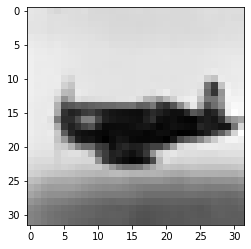

In [ ]:
# Definindo um nome para cada classificação dos rótulos
label = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Mostrar uma das imagens do conjunto de dados
plt.figure()
plt.imshow(X_train[115]);

Da mesma forma como no exercício 1, é necessário redimensionar os dados.

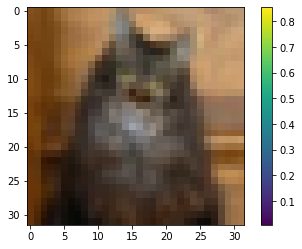

In [ ]:
# Transformar os dados de treino e teste 
X_train = X_train/255.0
X_test = X_test/255.0

plt.figure()
plt.imshow(X_train[26])
plt.colorbar();

Depois de preparar o conjunto de dados, é possível prosseguir para o modelo. 

O modelo é implementado usando a API Sequential do Keras, que é suficiente já que ela requer um dado de entrada e um dado de saída.

O modelo proposto possui camadas Conv2D-ReLU-MaxPool-Dropout, conforme pedido no enunciado. A seguir temos uma breve explicação de cada camada, já que cada processo foi previamente detalhado no exercício anterior.

- A camada Conv2D é uma camada de convolução usada para extrair features da imagem ou de parte de uma imagem. Ela cria um kernel de convolução que está envolvido com a camada de entrada para produzir um tensor de outputs. São passados três parâmetros:
  - filter_size (64): é um valor inteiro que determina o número de filtros na saída.
  - kernel_size (3,3): é o tamanho do filtro que passa pelas imagens. É dado como uma tupla de dois inteiros indicando a altura e largura.
  - activation (relu): é a função de regularização que controla o tipo e quantidade do método de regularização aplicado na etapa Conv2D.
- A camada MaxPooling2D reduz o tamanho dos dados, número de parâmetros e o poder computacional necessário. Ou seja, é similar a diminuir a escala do tamanho de uma imagem.
- A camada de BatchNormalization normaliza as entradas para cada batch.
- A camada Flatten converte o vetor em somente uma dimensão.
- A camada Dense é uma camda regular de neurônios em uma rede neural que estão densamente conectados. Cada neurônio recebe uma entrada dos demais neurônios.  


Abaixo definimos o modelo conforme pedido no enunciado e com os seguintes parâmetros:

- Feature maps = 64

- Kernel size = 3x3

- Input shape = 32x32

- Channels = 3

- Padding = 3 → Indica que deve ser a mesma dimensão para o output do que para o input.

A função de ativação usada é a `softmax`.


In [ ]:
# Definindo o modelo como uma sequência de camadas 
model = Sequential()

# Adicionando uma camada de convolução 
model.add(Conv2D(64, activation = 'relu', kernel_size = (3,3 )))

# Adicionando uma camada de MaxPooling
model.add(MaxPooling2D(pool_size = (2,2)))

# Adicionando uma normalização
model.add(BatchNormalization())

# Adicionando uma camada para comprimir os resultados
model.add(Flatten(input_shape = (32, 32, 3)))

# Dropout adicionado para regularização
model.add(Dropout(dropout))

# Camada de conexão densa - Dense(10)
model.add(Dense(len(label)))

# Ativação do Output: softmax
model.add(Activation('softmax'))

É necessário compilar o modelo antes do treinamento porque esse processo utiliza uma função perda (loss) para otimização.

Aqui, usamos a função `sparse_categorical_crossentropy`, que é uma função perda para dados categóricos. A diferença para a função perda usada anteriormente, `categorical_crossentropy`, se dá no formato da entrada dos dados de target e que para `sparse_categorical_crossentropy` existe a vantagem de economizar espaço de armazenamento. Ela é muito usada quando as classes são mutuamente exclusivas, que é o caso desse problema.

O otimizador é o mesmo que o usado no exercício 01, onde foi detalhado, assim como a métrica de avaliação do modelo, acurácia.

In [ ]:
# Compilando o modelo
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [ ]:
# Treinando o modelo
history = model.fit(X_train, y_train, epochs=10, verbose=1, validation_split=0.3)

Epoch 1/10
1094/1094 [==============================] - 24s 5ms/step - loss: 1.6673 - accuracy: 0.4355 - val_loss: 1.3520 - val_accuracy: 0.5397
Epoch 2/10
1094/1094 [==============================] - 5s 5ms/step - loss: 1.1665 - accuracy: 0.5944 - val_loss: 1.2807 - val_accuracy: 0.5564
Epoch 3/10
1094/1094 [==============================] - 5s 5ms/step - loss: 1.0752 - accuracy: 0.6241 - val_loss: 2.8788 - val_accuracy: 0.3522
Epoch 4/10
1094/1094 [==============================] - 5s 5ms/step - loss: 0.9965 - accuracy: 0.6525 - val_loss: 1.2601 - val_accuracy: 0.5810
Epoch 5/10
1094/1094 [==============================] - 5s 5ms/step - loss: 0.9305 - accuracy: 0.6737 - val_loss: 1.2732 - val_accuracy: 0.5847
Epoch 6/10
1094/1094 [==============================] - 5s 5ms/step - loss: 0.8890 - accuracy: 0.6916 - val_loss: 1.3482 - val_accuracy: 0.5751
Epoch 7/10
1094/1094 [==============================] - 5s 5ms/step - loss: 0.8442 - accuracy: 0.7089 - val_loss: 1.2531 - val_accuracy

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 30, 30, 64)        1792      
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 15, 15, 64)        0         
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 15, 15, 64)        256       
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 14400)             0         
_________________________________________________________________
dropout (Dropout)            (None, 14400)             0         
_________________________________________________________________
module_wrapper_4 (ModuleWrap (None, 10)                144010    
_________________________________________________________________
module_wrapper_5 (ModuleWrap (None, 10)                0

Abaixo temos também a visualizaçao do esquema da rede.

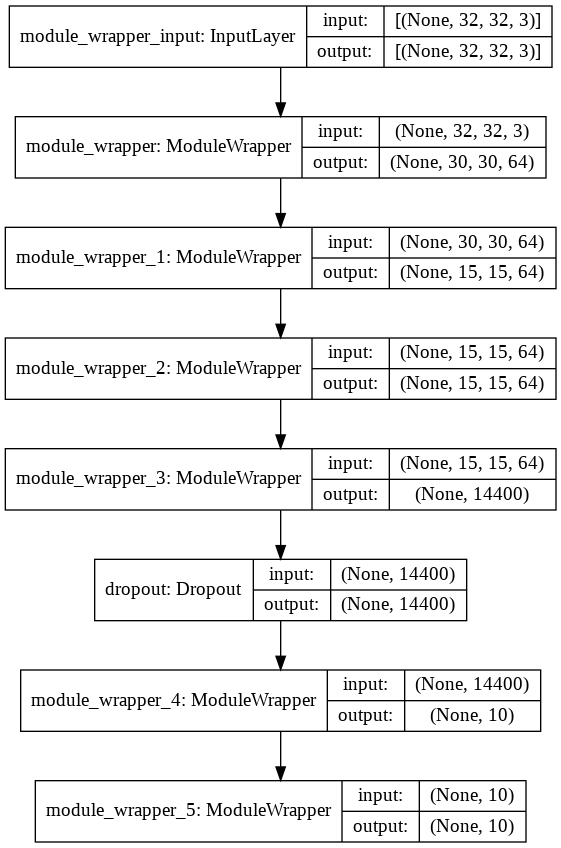

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='cnn-cifar.png', show_shapes=True)

Abaixo temos a função perda e a acurácia nos dados de teste que é de 1.41 e 58%, respectivamente. Ainda há espaço para melhoria da rede, já que as métricas não sugerem assertividade tão grande. Uma possível sugestão seria aumentar o número de camadas, por exemplo.

In [ ]:
# Calculando loss e acurácia nos dados de teste
test_loss, test_acc = model.evaluate(X_test, y_test)
test_loss, test_acc

313/313 [==============================] - 1s 3ms/step - loss: 1.4034 - accuracy: 0.5691


(1.4033600091934204, 0.569100022315979)

In [ ]:
from sklearn.metrics import accuracy_score
y_pred = np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test,y_pred)

0.5691

Abaixo temos a previsão para os dados de teste. Com o exemplo da observação de índice 6, vemos que a maior probabilidade estimada é que essa imagem seria de um automóvel.

In [ ]:
pred = model.predict(X_test)
pred[6]

array([4.4180769e-03, 7.1271521e-01, 3.4413385e-04, 5.9286790e-04,
       9.1714895e-08, 7.8992605e-05, 6.7837580e-05, 6.1810276e-08,
       3.0654737e-06, 2.8177974e-01], dtype=float32)

A probabilidade arredondada que se iguala a 1 equivale ao rótulo (label) de índice 2, que nesse caso é um automóvel.

In [ ]:
np.round(pred[6], 0)

array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
label

['Airplane',
 'Automobile',
 'Bird',
 'Cat',
 'Deer',
 'Dog',
 'Frog',
 'Horse',
 'Ship',
 'Truck']

Na imagem abaixo, vemos que de fato a imagem se refere a um automóvel.

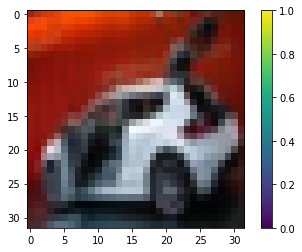

In [ ]:
plt.figure()
plt.imshow(X_test[6])
plt.colorbar();

A seguir temos a função perda e a acurácia de acordo com cada época.

Existem alguns pontos a serem observados entre:

1.  A função perda (loss) para dados de validação e para dados de treinamento:

  a. A função perda de validação deve ser similar, mas levemente maior que a função perda de treinamento.

  b. Se a função perda de treinamento é muito maior que a de validação, o modelo está ajustado demais aos dados de treinamento, ou seja, está ocorrendo _overfitting_.
  
  c. Se a função perda de treinamento é muito menor que a de validação, o modelo está pouco ajustado aos dados de treinamento, ou seja, está ocorrendo _underfitting_.

  Nesse caso, vemos que não ocorre nenhum dos problemas de _overfitting_ ou _underfitting_, já que o caso se aplica a (1.a);

2. A função perda (loss) para dados de validação e acurácia nos dados de validação:

  a. Se a função perda nos dados de validação aumenta enquanto a acurácia na validação diminui, o modelo não está aprendendo.
  
  b. Se a função perda nos dados de validação e a acurácia na validação aumentam, o modelo está com _overfitting_. 
  
  c. Se a função perda nos dados de validação diminuir enquando a acurácia na validação aumenta, o modelo está adequado.

  É possível ver que o modelo está adequado, já que o caso se aplica a (2.c).

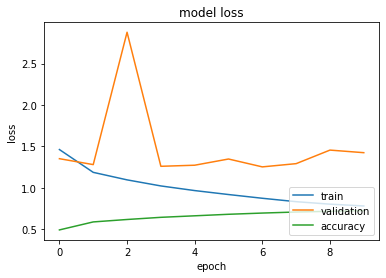

In [ ]:
def plotloss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['accuracy'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation', 'accuracy'], loc = 'lower right')
    plt.show()

plotloss(history)